In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib widget

import pandas as pd
import geopandas as gpd

from air_brain.data.get_data import DATA_DIR
from air_brain.util.air import PM25
from air_brain.util.od import od

county_file = os.path.join(DATA_DIR, "county.geojson")
sensor_file = os.path.join(DATA_DIR, "sensor_json.geojson")

<Axes: >

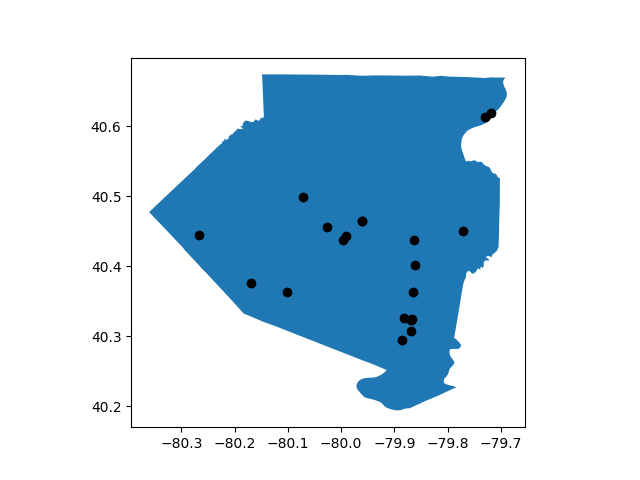

In [2]:
# where all the sensors are in the county
county = gpd.read_file(county_file)
sensors = gpd.read_file(sensor_file)

ax = county.plot()
sensors.plot(ax=ax, color="black")

In [3]:
sensors.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# import in overdose data and make into geopandas
od_df = od()
# TODO geojson ify this
# so it imports as geopandas
zip2latlon = pd.read_csv(os.path.join(DATA_DIR, "zip2latlon.csv"))
od_df = od_df.merge(zip2latlon, how='left')
# geopandas - ify
od_df = gpd.GeoDataFrame(
    od_df, geometry=gpd.points_from_xy(od_df.longitude, od_df.latitude), crs="EPSG:4326")

Text(0.5, 1.0, '2020-06-03 00:00:00')

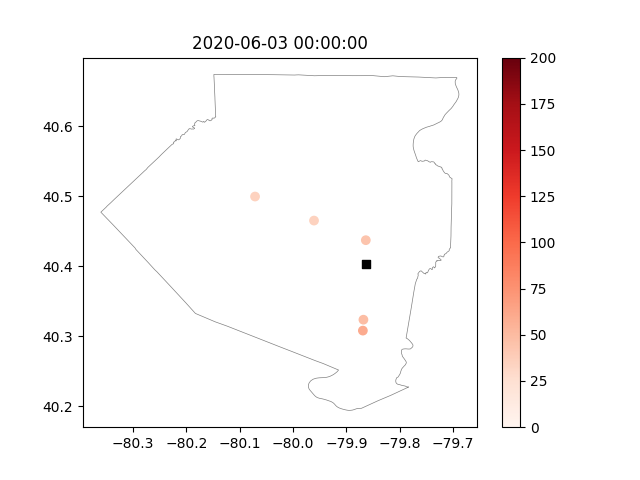

In [5]:
# pm 2.5 sensor values at a point in time
df = PM25().daily_air()
df = sensors[['SiteName', 'geometry']].rename(columns={'SiteName': 'site'}).merge(df, on='site', how='right', validate='1:m')

date = pd.to_datetime('6/3/2020')
subset = df.loc[df.date == date]

county["boundary"] = county.boundary
ax = county["boundary"].plot(color="grey", linewidth=0.5)
subset.plot("index_value", ax=ax, legend=True, vmin=0, vmax=200, cmap="Reds")

# include accidental overdose incidents, with zipcode centroid location
od_subset = od_df.loc[od_df.date == date]
try:
    od_subset.plot(ax=ax, color="black", marker="s")
except ValueError:
    pass

# make it easier to understand
ax.set_title(date)

0

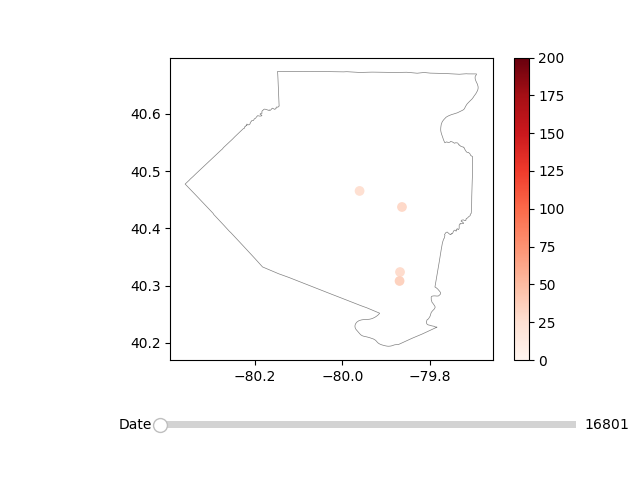

In [6]:
# make a slider to vary over time
min_date = max(df.date.min(), od_df.date.min())
max_date = min(df.date.max(), od_df.date.max())

# plot for one date
def to_plot(ax, df, date):
    subset = df.loc[df.date == date]
    subset.plot("index_value", ax=ax, legend=True, vmin=0, vmax=200, cmap="Reds")

# initialize
fig, ax = plt.subplots()
county["boundary"].plot(ax=ax, color="grey", linewidth=0.5)
to_plot(ax, df, min_date)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# horizontal slider to control the date
axdate = fig.add_axes([0.25, 0.1, 0.65, 0.03])
date_slider = Slider(
    ax=axdate,
    label='Date',
    valmin=matplotlib.dates.date2num(min_date),
    valmax=matplotlib.dates.date2num(max_date),
    valinit=matplotlib.dates.date2num(min_date),
)

# call anytime the slider's value changes
def update(val):
    to_plot(ax, df, matplotlib.dates.num2date(val))

# register the update function with the slider
date_slider.on_changed(update)